In [1]:
import torch
import sys

sys.path.insert(1, '/home/rens/repos/hover_net')

from models.hovernet.net_desc import HoVerNet

net = HoVerNet(nr_types=6,mode='fast')
ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
net.load_state_dict(ckpt['desc'], strict=True)
net.eval()
print('Setup complete')

Setup complete


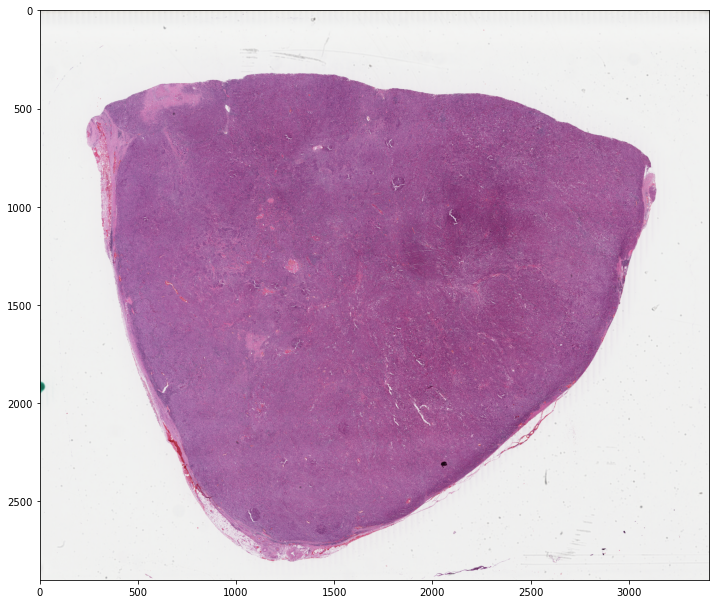

(109165, 92862)


In [2]:
import openslide
import numpy as np
import matplotlib.pyplot as plt


img = openslide.OpenSlide(file_path)
image = np.array(img.read_region((0,0), 3, img.level_dimensions[3]).convert('RGB'))

plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

print(img.level_dimensions[0])

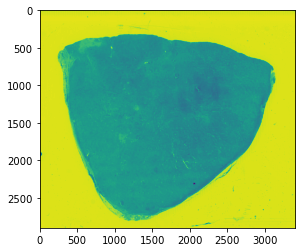

In [3]:
plt.imshow(image.sum(axis=-1))

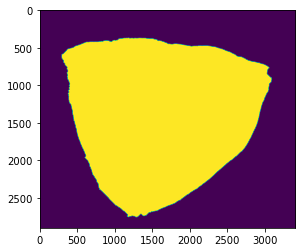

In [4]:
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion

mask = image.sum(axis=-1) < 600
filled_mask = binary_fill_holes(mask)
eroded_mask = binary_erosion(filled_mask, iterations=50)

plt.imshow(eroded_mask)
plt.show()

In [5]:
dimensions = np.array(img.level_dimensions)

xx = np.arange(0,img.dimensions[0], 164)[:-1]
yy = np.arange(0,img.dimensions[1], 164)[:-1]

origins = np.array([(x,y) for y in yy for x in xx])

downsampled_origins = (origins / dimensions[0] * dimensions[3]).astype(int)

filtered_origins = origins[[eroded_mask[y,x] for x,y in downsampled_origins]]

In [11]:
from monai.transforms import Lambdad, Compose, ToTensord
from monai.data import CacheDataset
from torch.utils.data import DataLoader

input = [{'origin':origin, 'image':origin} for origin in filtered_origins]

transforms = Compose([
    Lambdad(
        keys='image', 
        func=lambda x: img.read_region(
            (x[0] - 46, x[1] - 46),
            0,
            (256,256)
        )
    ),
    Lambdad(
        keys='image', 
        func = lambda x: np.array(x).transpose(2,0,1)[:-1]
    ),
    ToTensord(keys='image')
])

ds = CacheDataset(input, transform=transforms, cache_rate=0)
dl = DataLoader(ds, batch_size=4)

In [1]:
import sys
import torch
import geojson
import openslide
import numpy as np
from pytorch_lightning import LightningModule
from monai.transforms import Lambdad, Compose, ToTensord
from monai.data import CacheDataset
from torch.utils.data import DataLoader
from util import format_output, output2annotations
from scipy.ndimage.morphology import binary_fill_holes, binary_erosion

sys.path.insert(1, '/home/rens/repos/hover_net')

from models.hovernet.net_desc import HoVerNet


class Processor(LightningModule):
    def __init__(self, slide_path):
        super().__init__()

        # setup hovernet
        self.net = HoVerNet(nr_types=6,mode='fast')
        ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
        self.net.load_state_dict(ckpt['desc'], strict=True)

        # open slide
        self.slide = openslide.OpenSlide(str(slide_path))
        dimensions = np.array(self.slide.level_dimensions)

        # create mask
        image = np.array(self.slide.read_region((0,0), 3, self.slide.level_dimensions[3]).convert('RGB'))
        mask = image.sum(axis=-1) < 650
        filled_mask = binary_fill_holes(mask)
        # eroded_mask = binary_erosion(filled_mask, iterations=50)

        # create and filter list of origins which will be inferenced
        xx = np.arange(0,self.slide.dimensions[0], 164)[:-1]
        yy = np.arange(0,self.slide.dimensions[1], 164)[:-1]

        origins = np.array([(x,y) for y in yy for x in xx])
        downsampled_origins = (origins / dimensions[0] * dimensions[3]).astype(int)
        filtered_origins = origins[[filled_mask[y,x] for x,y in downsampled_origins]]

        # self.input is the input to the dataset
        self.input = [{'origin':origin, 'image':origin} for origin in filtered_origins]

        # output classes
        self.classes = {
            0 : "nolabe",
            1 : "neopla",
            2 : "inflam",
            3 : "connec",
            4 : "necros",
            5 : "no-neo",
        }

        # list for storing outputted annotations
        self.output = []

    def forward(self, x):
        return self.net(x)

    def test_dataloader(self):
        self.ds = CacheDataset(
            self.input,
            transform=Compose([
                Lambdad(
                    keys='image', 
                    func=lambda x: np.array(processor.slide.read_region(
                        (x[0] - 46, x[1] - 46),
                        0,
                        (256,256)
                    ).convert('RGB'))
                ),
                Lambdad(
                    keys='image',
                    func=lambda x: normalize_staining(x)[0]
                ),
                Lambdad(
                    keys='image', 
                    func = lambda x: x.transpose(2,0,1)
                ),
                ToTensord(keys='image')
            ]),
            cache_rate=0.01
        )

        return DataLoader(ds, batch_size=16)

    def test_step(self, batch, batch_ix):
        self.current_batch = batch

        origins, images, _ = batch.values()
        output = self.net(images)

        for k in output.keys():
            output[k] = output[k].detach().cpu()

        formatted_output = format_output(output)
        annotations = [output2annotations(pred) for pred in formatted_output]
        
        for origin, annotation in zip(origins, annotations):
            for instance in annotation.values():
                dict_data = {}

                cc = (origin.cpu().numpy() + instance['contour']).tolist()
                cc.append(cc[0])

                dict_data["type"]="Feature"
                dict_data["id"]="PathCellObject"
                dict_data["geometry"]={
                    "type":"Polygon",
                    "coordinates":[cc]
                }
                dict_data["properties"]={
                    "isLocked":"false",
                    "measurements":[],
                    "classification": {
                        "name": self.classes[instance['type']]
                    }
                }

                self.output.append(dict_data)

    def save(self, save_path):
        with open(save_path, 'w') as file:
            geojson.dump(self.output, file)

In [2]:
from pytorch_lightning import Trainer

file_path = '/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-127_6e451b5557 I4 HE1 - 2022-03-25 14.16.02.ndpi'

processor = Processor(
    file_path
)

# trainer = Trainer(gpus=1)
# trainer.test(processor)

In [3]:
from util import normalize_staining

ds = CacheDataset(
    processor.input,
    transform=Compose([
        Lambdad(
            keys='image', 
            func=lambda x: np.array(processor.slide.read_region(
                (x[0] - 46, x[1] - 46),
                0,
                (256,256)
            ).convert('RGB'))
        ),
        Lambdad(
            keys='image',
            func=lambda x: normalize_staining(x)[0]
        ),
        Lambdad(
            keys='image', 
            func = lambda x: x.transpose(2,0,1)
        ),
        ToTensord(keys='image')
    ]),
    cache_rate=0
)

In [8]:
ds[3]

{'origin': array([57400,   164]),
 'image': tensor([[[219, 220, 220,  ..., 232, 232, 232],
          [219, 220, 220,  ..., 232, 231, 232],
          [222, 218, 216,  ..., 227, 229, 230],
          ...,
          [218, 217, 219,  ..., 232, 231, 231],
          [218, 217, 219,  ..., 231, 231, 231],
          [216, 216, 218,  ..., 231, 231, 231]],
 
         [[208, 209, 209,  ..., 221, 222, 222],
          [208, 209, 209,  ..., 220, 221, 222],
          [205, 204, 203,  ..., 219, 221, 222],
          ...,
          [212, 211, 210,  ..., 219, 220, 220],
          [211, 210, 210,  ..., 219, 220, 220],
          [208, 208, 208,  ..., 219, 220, 220]],
 
         [[224, 225, 225,  ..., 238, 230, 231],
          [225, 226, 226,  ..., 240, 229, 231],
          [221, 219, 220,  ..., 234, 234, 235],
          ...,
          [216, 215, 213,  ..., 236, 236, 234],
          [218, 217, 215,  ..., 233, 236, 234],
          [219, 219, 219,  ..., 229, 236, 234]]], dtype=torch.uint8),
 'image_transforms':

In [11]:
ds[0]

{'origin': array([66256,     0]),
 'image': array([[[ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60],
         ...,
         [ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60]],
 
        [[ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60],
         ...,
         [ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60]],
 
        [[ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60],
         ...,
         [ 63,  25,  60],
         [ 63,  25,  60],
         [ 63,  25,  60]],
 
        ...,
 
        [[235, 232, 235],
         [235, 231, 234],
         [234, 231, 234],
         ...,
         [235, 231, 235],
         [234, 231, 234],
         [235, 232, 235]],
 
        [[235, 232, 235],
         [235, 232, 235],
         [235, 231, 234],
         ...,
         [234, 231, 234],
         [235, 232, 235],
         [235, 232, 235]],
 
        [[235, 232, 235],
         [235, 231, 235],
         [235, 232, 235],

In [3]:
import json
from pathlib import Path

r = Path(r'/data/data/pathology/isala/re_hovernet_output')

data = []

for file in r.iterdir():
    with open(file) as f:
        annotations = json.load(f)
    data.extend(annotations)

In [5]:
import geojson

with open('/data/data/pathology/tcga/test/geojson.json', 'w') as file:
    geojson.dump(data, file)



In [12]:
import numpy as np

center_of_mass = np.array(data[0]['geometry']['coordinates']).mean(axis=(0,1))

array([50201.96153846, 33136.57692308])

In [1]:
import geojson
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

r = Path('/home/rens/hpc/rens/output/hovernet_re_output')

for f in sorted(list(r.iterdir()))[10:]:
    print(f.name)
    with open(f, 'r') as file:
        data = geojson.load(file)

    tils = []
    for annotation in tqdm(data):
        if annotation['properties']['classification']['name'] == 'inflam':
            tils.append(annotation)

    with open(r.parent / 'hovernet_only_tils' / f.name, 'w') as file2:
        geojson.dump(tils, file2)

PREM-IS-137_6d9eb60430 I1 HE1 - 2022-03-25 13.37.29.json


  0%|          | 0/1188687 [00:00<?, ?it/s]

In [4]:
r.parent / 'hovernet_only_tils' /

PosixPath('/home/rens/hpc/rens/output/hovernet_only_tils')

In [5]:
coms = []
for annotation in tqdm(data):
    if annotation['properties']['classification']['name'] == 'inflam':
        center_of_mass = np.array(annotation['geometry']['coordinates']).mean(axis=(0,1))
        coms.append(center_of_mass)

coms = np.stack(coms)

  0%|          | 0/1430348 [00:00<?, ?it/s]

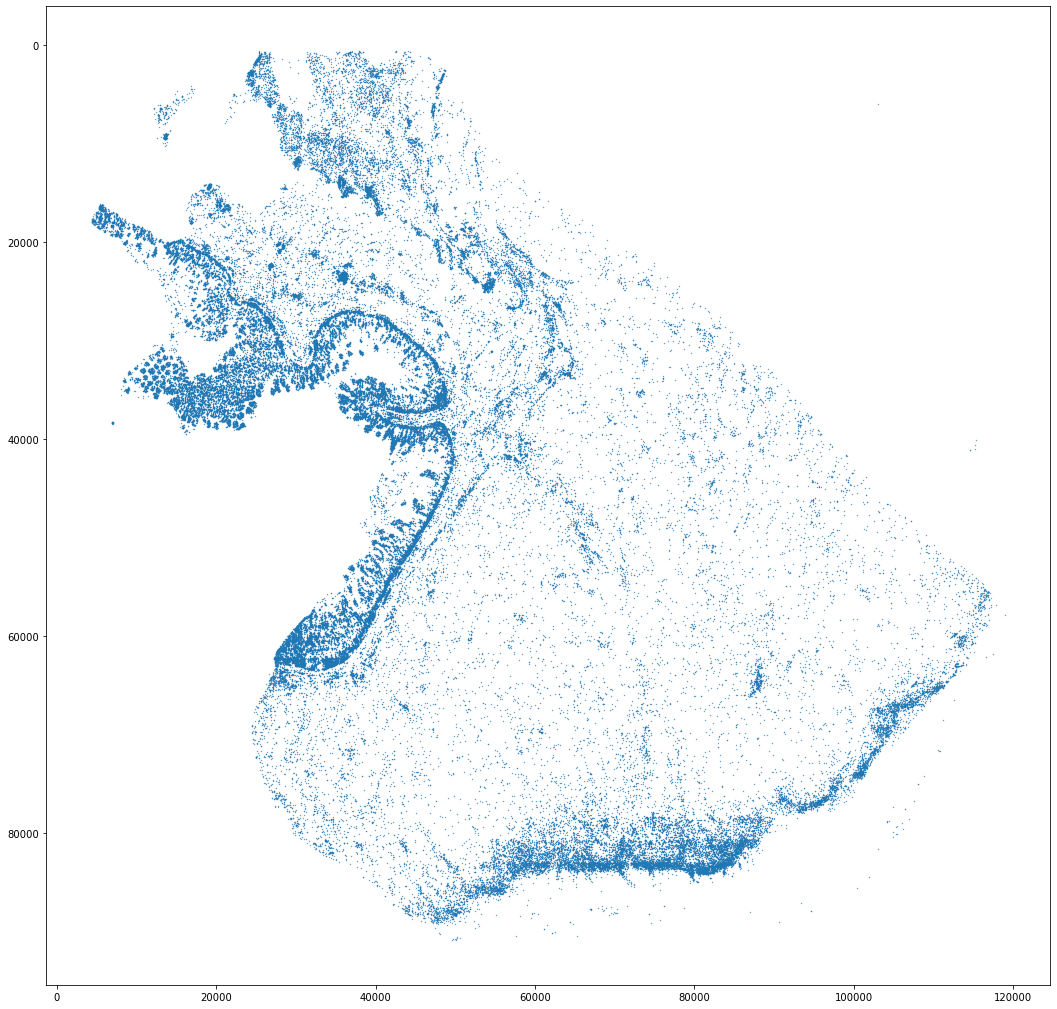

In [8]:


plt.figure(figsize=(18,18))
plt.scatter(coms[:,0],coms[:,1], s=0.1)

ax = plt.gca()
ax.invert_yaxis()

plt.show()

In [47]:
import geojson

with open('/data/data/pathology/isala/re_hovernet_output/test.json', 'w') as file:
    geojson.dump(geo_data, file)

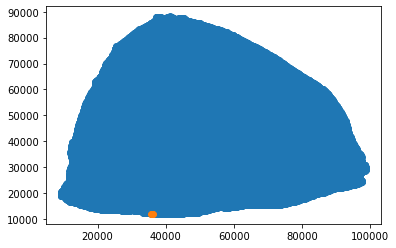

In [52]:
plt.scatter(filtered_origins[:,0], filtered_origins[:,1])
plt.scatter(origins[:,0], origins[:,1])

In [51]:
origins

tensor([[35752, 11972],
        [35916, 11972],
        [36080, 11972],
        [36244, 11972]])

In [26]:
origin[0] + annotation[k]['contour']

tensor([[35837, 11972],
        [35837, 11973],
        [35838, 11974],
        [35838, 11976],
        [35839, 11977],
        [35839, 11978],
        [35842, 11981],
        [35843, 11981],
        [35844, 11982],
        [35847, 11982],
        [35848, 11983],
        [35852, 11983],
        [35855, 11980],
        [35855, 11978],
        [35856, 11977],
        [35856, 11975],
        [35857, 11974],
        [35857, 11972]])

In [12]:
xxs, yys = origins[:,0], origins[:,1]
downsampled_xxs = (xxs / img.dimensions[0] * img.level_dimensions[3][0]).astype(int)
downsampled_yys = (yys / img.dimensions[1] * img.level_dimensions[3][1]).astype(int)

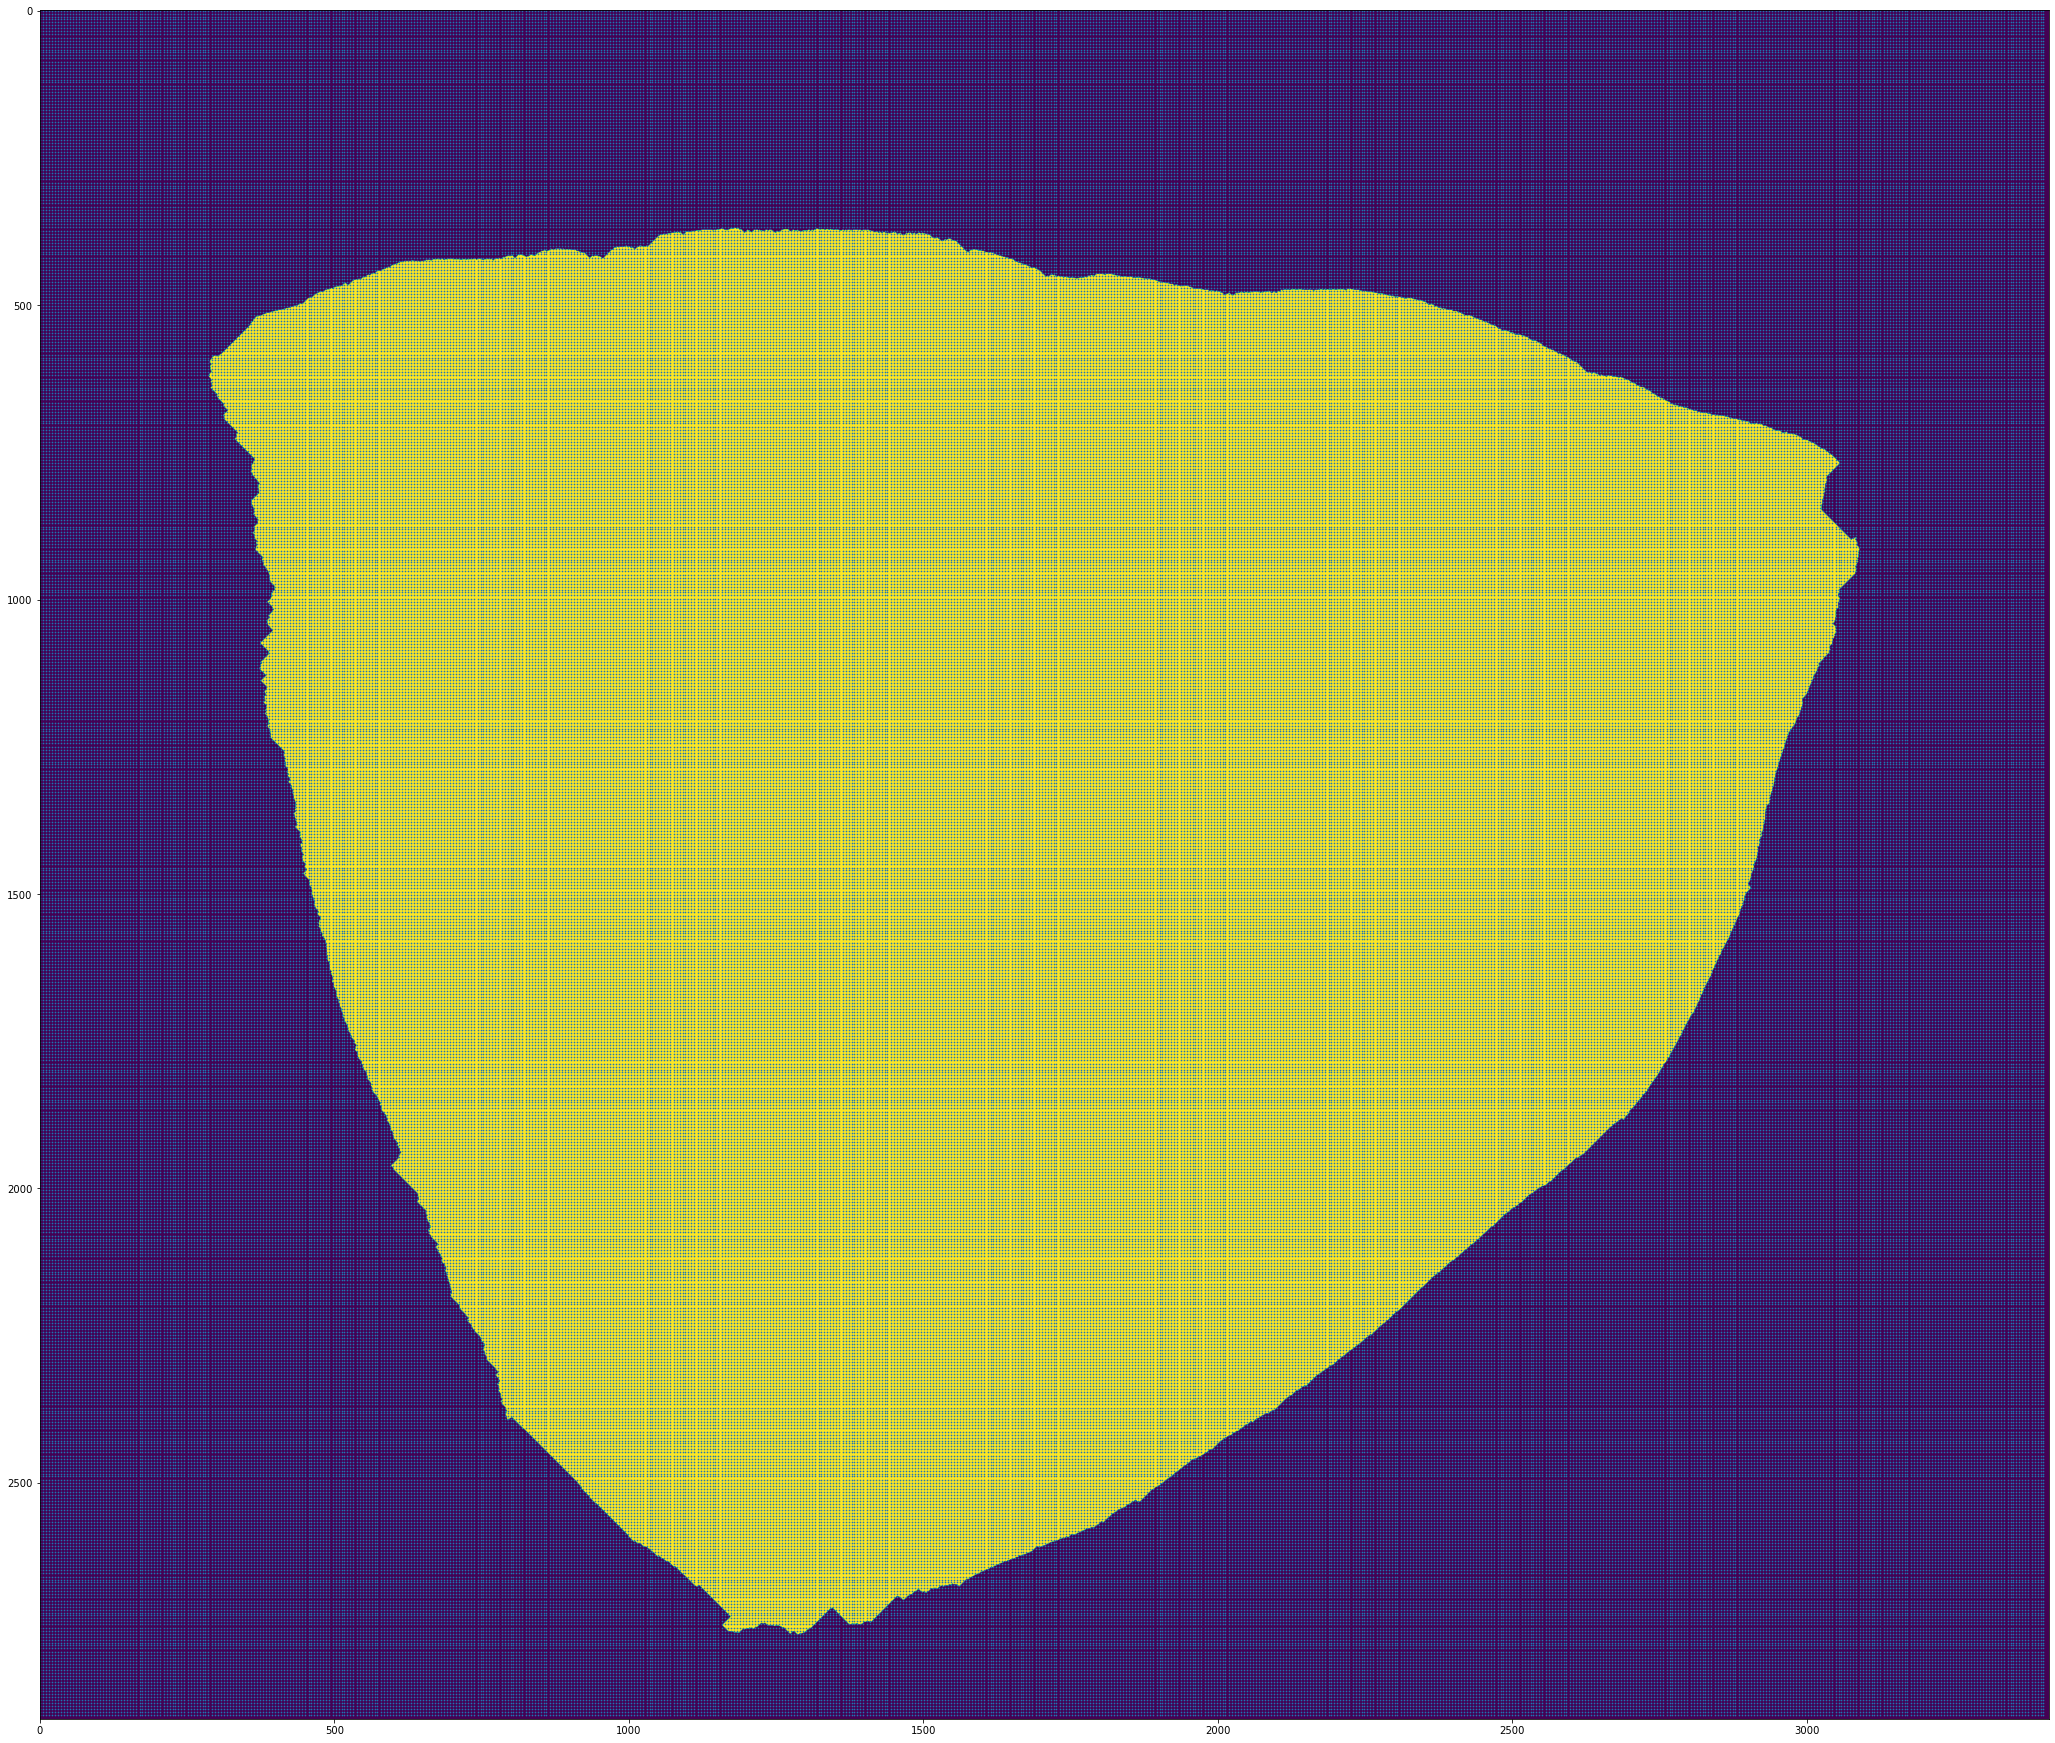

In [22]:
plt.figure(figsize=(36,36))
plt.imshow(eroded_mask)
plt.scatter(downsampled_xxs, downsampled_yys, s=0.5)
plt.show()